# 지도학습 (Supervised Learning)

* 절차 : 목적 설정 -> 데이터 준비 -> 가공 -> 기법적용 -> 검증

* 세부적인 절차는 아래와 같다.

1. 데이터를 로드 한 후 데이터의 형(type), 기초통계량 확인

2. 훈련용 데이터와 테스트 데이터를 분류

3. 모형 적합 후 모형확인 -> 유의하지 않은 변수가 많을 경우 step 함수를 이용하여 적절히 변수선택법을 사용

4. 모형 적합 후 검증 : ROC curve, AUC, 정확도, 특이도, 민감도 등을 확인

# 0. Package for Supervised Learning

In [4]:
library(tidyverse) ##전처리 패키지
library(caret) ## confusion matrix를 만들기 위한 패키지
library(nnet) ##  다항 로지스틱 회귀분석 모델을 적합하기 위한 패키지
library(ROCR)

# 1. 로지스틱 회귀분석

* 로지스틱 회귀분석은 지도학습 기법 중 가장 기본이 되는 분석기법이다.

$$\begin{eqnarray*} P\,(Y) = \frac {1}{1+exp\left[ -\,(\beta_0 + \beta_1x_1+\dots\right)]}\end{eqnarray*}$$

* $x_i$가 한 단위 증가할때 $log(odds)$는 $\beta_i$ 만큼 증가한다.

* 다른 분류기법들과 다르게 특정 범주의 속할 확률을 계산한뒤 임계치를 기준으로 분류한다.

## 1-1. R을 이용한 이항 로지스틱

In [5]:
setwd("C:\\Users\\lee\\Desktop\\PART 05 실습용 데이터")
credit_data <- read_csv("credit_final.csv")
#glimpse(credit_data) ## credit.rating의 경우 factor 변수이므로 변환
credit_data$credit.rating <- as_factor(credit_data$credit.rating)

Rows: 1000 Columns: 21

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (21): credit.rating, account.balance, credit.duration.months, previous.c...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [6]:
# summary(credit_data)
## 데이터 분할 각각의 데이터를 7:3으로 나눔
train <- credit_data %>% sample_frac(0.7)
test <- credit_data %>% setdiff(train)

In [7]:
## 로지스틱 회귀모형 적합
logit_fit <-glm(credit.rating~., data =train, 
                family = "binomial") ## 이진분류이므로 "binomial"이라고 기입

# summary(logit_fit)

step.logit <- step(glm(credit.rating~., data =train, 
    family = "binomial"),direction = 'both')

# summary(step.logit) ## 총 12개의 변수가 채택됨
# length(step.logit$coefficients)


pred <- predict(step.logit, test %>% select(-1),type="response") %>% as_tibble()
pred <- pred %>% mutate(hat_y = as.factor(ifelse(value>0.5,1,0)))

Start:  AIC=695.13
credit.rating ~ account.balance + credit.duration.months + previous.credit.payment.status + 
    credit.purpose + credit.amount + savings + employment.duration + 
    installment.rate + marital.status + guarantor + residence.duration + 
    current.assets + age + other.credits + apartment.type + bank.credits + 
    occupation + dependents + telephone + foreign.worker

                                 Df Deviance    AIC
- residence.duration              1   653.14 693.14
- dependents                      1   653.18 693.18
- occupation                      1   653.19 693.19
- age                             1   653.21 693.21
- guarantor                       1   653.34 693.34
- bank.credits                    1   653.76 693.76
- foreign.worker                  1   654.15 694.15
<none>                                653.13 695.13
- employment.duration             1   655.13 695.13
- other.credits                   1   655.68 695.68
- apartment.type                  1   

In [7]:
confusionMatrix(data=pred$hat_y,reference = test$credit.rating,positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  40  23
         1  56 181
                                         
               Accuracy : 0.7367         
                 95% CI : (0.683, 0.7856)
    No Information Rate : 0.68           
    P-Value [Acc > NIR] : 0.0192801      
                                         
                  Kappa : 0.3343         
                                         
 Mcnemar's Test P-Value : 0.0003179      
                                         
            Sensitivity : 0.8873         
            Specificity : 0.4167         
         Pos Pred Value : 0.7637         
         Neg Pred Value : 0.6349         
             Prevalence : 0.6800         
         Detection Rate : 0.6033         
   Detection Prevalence : 0.7900         
      Balanced Accuracy : 0.6520         
                                         
       'Positive' Class : 1              
                                         

[[1]]
[1] 0.6519608

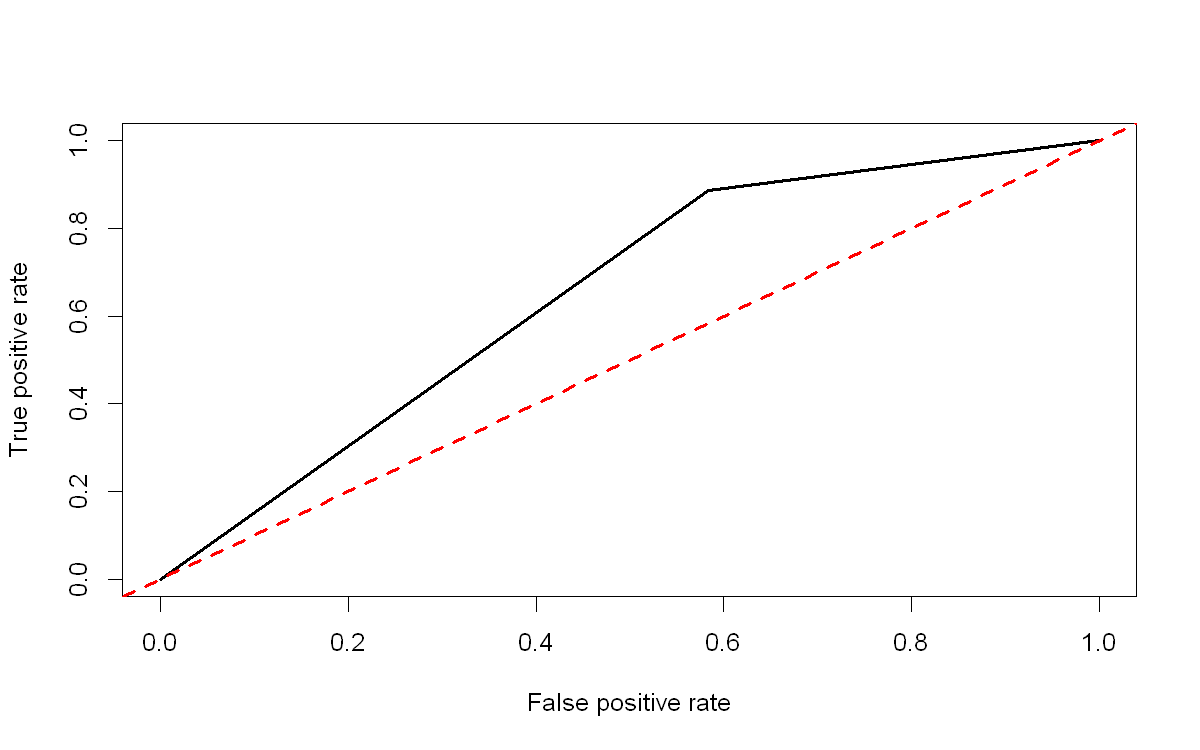

In [8]:
options(repr.plot.res=150,repr.plot.width=8,repr.plot.height=5)
pred.roc <- prediction(as.numeric(pred$hat_y),as.numeric(test$credit.rating))
plot(performance(pred.roc,"tpr","fpr"),lwd=2)
abline(a=0,b=1,lty="dashed",col="red",lwd=2)
performance(pred.roc,"auc")@y.values

* 위를 살펴보면 기존의 로지스틱회귀 모형을 적합했을 때 유의미하지 않은 변수가 다수 보여 단계적 변수 선택법을 적용하여 모델을 적합시켰다.

* 정확도는 약 73%, 민감도와 특이도는 각각 85%, 44%로 측정되었으며, AUC값은 0.6484로 산출되었다. 그닥 훌륭한 모델이라고 보기 어렵다.

## 1-2. 다항로지스틱

In [9]:
##iris 데이터를 이용한 다항 로지스틱 회귀분석
train.iris <- iris %>% sample_frac(0.7)
test.iris <- iris %>% setdiff(train.iris)

mul.iris <- multinom(Species~.,train.iris)
summary(mul.iris)

# weights:  18 (10 variable)
initial  value 115.354290 
iter  10 value 11.452176
iter  20 value 3.153238
iter  30 value 2.649388
iter  40 value 2.341641
iter  50 value 2.256572
iter  60 value 1.995702
iter  70 value 1.245143
iter  80 value 0.904025
iter  90 value 0.621338
iter 100 value 0.603201
final  value 0.603201 
stopped after 100 iterations


Call:
multinom(formula = Species ~ ., data = train.iris)

Coefficients:
           (Intercept) Sepal.Length Sepal.Width Petal.Length Petal.Width
versicolor    51.48231    -30.82089   -21.44772     85.88038    24.74862
virginica    -96.62251    -68.87111   -61.97239    164.13765    94.06323

Std. Errors:
           (Intercept) Sepal.Length Sepal.Width Petal.Length Petal.Width
versicolor    121.5106     132.8265    97.66829     74.74537    36.83325
virginica     118.3141     144.8161   106.79819     64.21134    33.88914

Residual Deviance: 1.206402 
AIC: 21.2064 

In [10]:
pred.mul <- predict(mul.iris,test.iris %>% select(-5)) 
confusionMatrix(pred.mul,test.iris$Species)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         13          0         0
  versicolor      0         16         0
  virginica       0          1        15

Overall Statistics
                                          
               Accuracy : 0.9778          
                 95% CI : (0.8823, 0.9994)
    No Information Rate : 0.3778          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9665          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9412           1.0000
Specificity                 1.0000            1.0000           0.9667
Pos Pred Value              1.0000            1.0000           0.9375
Neg Pred Value              1.0000            0.9655           1.0000
P

***

# 2. 의사결정나무

* 분류함수를 의사결정 규칙으로 이뤄진 나무 모양으로 그리는 방법
* 분할 횟수가 많을 경우 모형이 복잡해지는 것을 방지하기 위해 가지치기 단계를 적용한다.

## 2-1. binary classification

In [11]:
library(rpart)
library(rpart.plot)

In [23]:
dt.model <- rpart(credit.rating~.,method="class", ## 회귀가 아닌 분류이므로 "class" 기입
                                   data = train, 
                                   control = rpart.control(maxdepth=5,
                                                           minsplit=15)) ## 의사결정나무의 최대 깊이는 5, 노드에서의 최소 관측치는 15개이 상

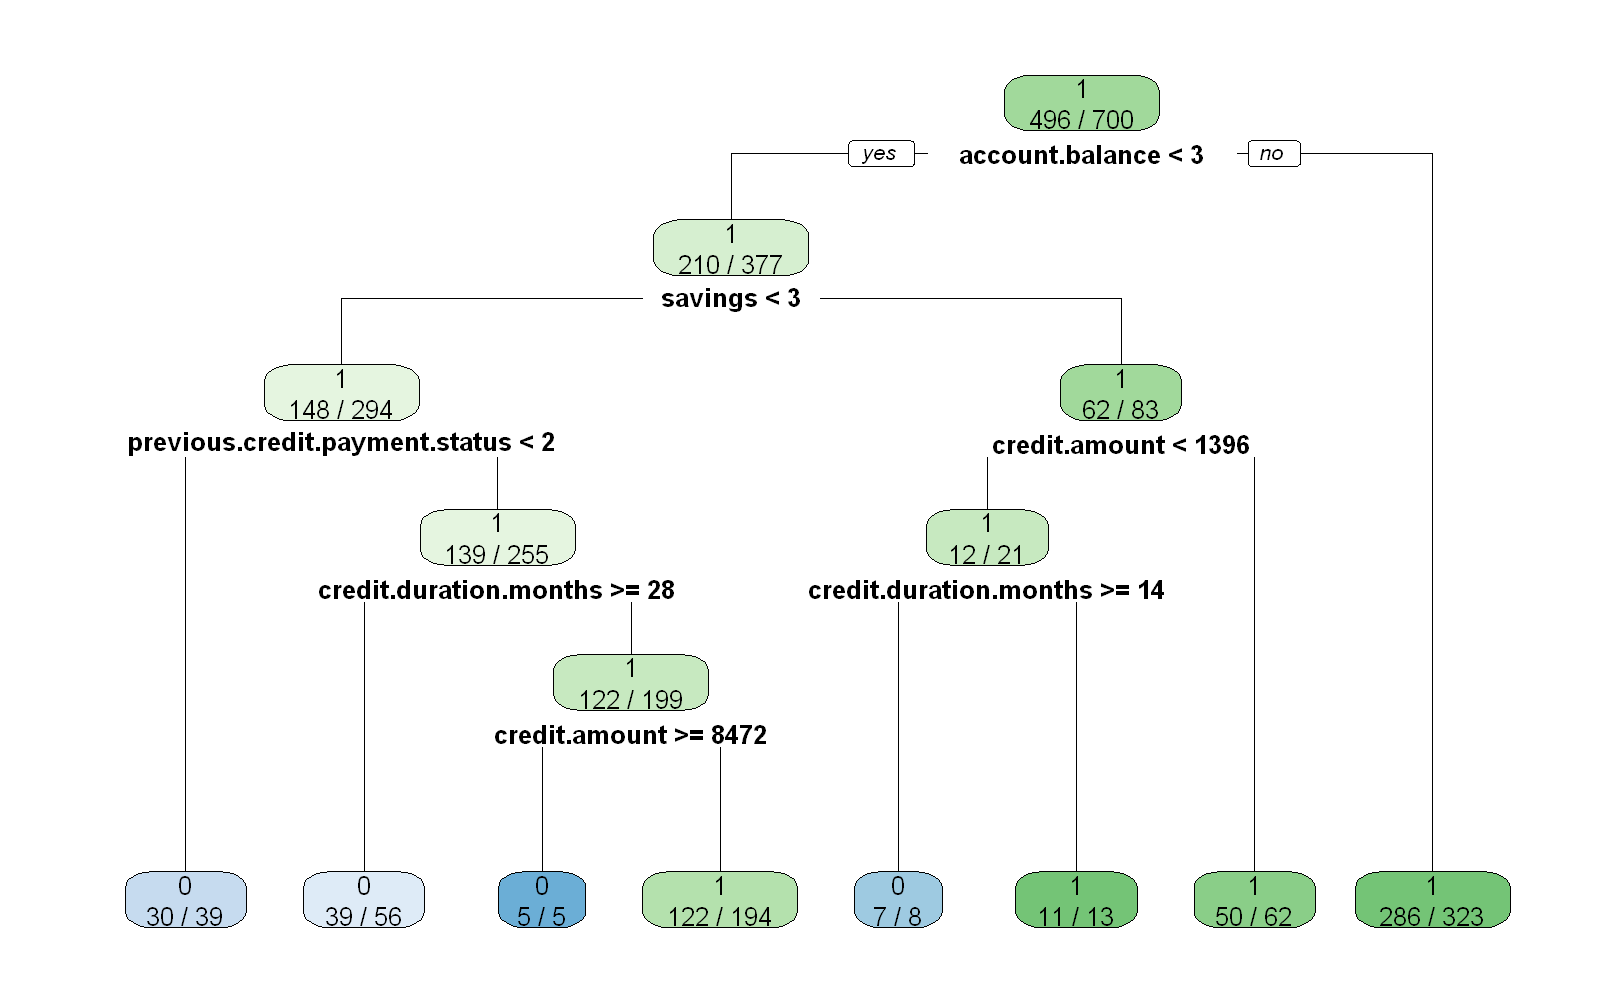

In [24]:
options(repr.plot.res=200)
rpart.plot(dt.model,extra=2) ## extra 인자를 이용해 각각 범주의 분류된 개수를 파악, extra=3 은 오분류된 개수를 보여주

* 총 700개의 관측치 중 496개의 관측치를 1로 분류하였으며, `account.balance <3` 인 377개의 노드 중 210개가 1로 분류되었음을 의미한다.

* cptable을 확인하여 xerror가 가장 낮은 split 개수를 택한 후 가지치기를 적용하자.
* `xerror`는해당 `CP`에서 교차검증오류를 나타내며 `CP`는 복잡성을 나타낸다. 

In [25]:
dt.model$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.05269608,0,1.0000000,1.0000000,0.05893547
2,0.02450980,4,0.7892157,0.9264706,0.05757874
3,0.01470588,5,0.7647059,0.8872549,0.05678633
4,0.01000000,7,0.7352941,0.8872549,0.05678633


* 확인 결과 `xerror`가 가장 낮은 분할 횟수는 7이며, 앞선 모형의 그래프를 봤을 때 모델이 분할을 7번까지 한다고 할 수 있다.

* 해당 위치에서의 `CP` 값을 전달받자

In [26]:
opt <- which.min(dt.model$cptable[,"xerror"])
cp  <- dt.model$cptable[opt,"CP"]

* plotcp를 그려본결과 8번째 분할에서 `xerror`가 가장 낮지만 과적합을 막기위해 `cptable`에서 산출한 `cp`값을 이용하여 가지치기를 하자.

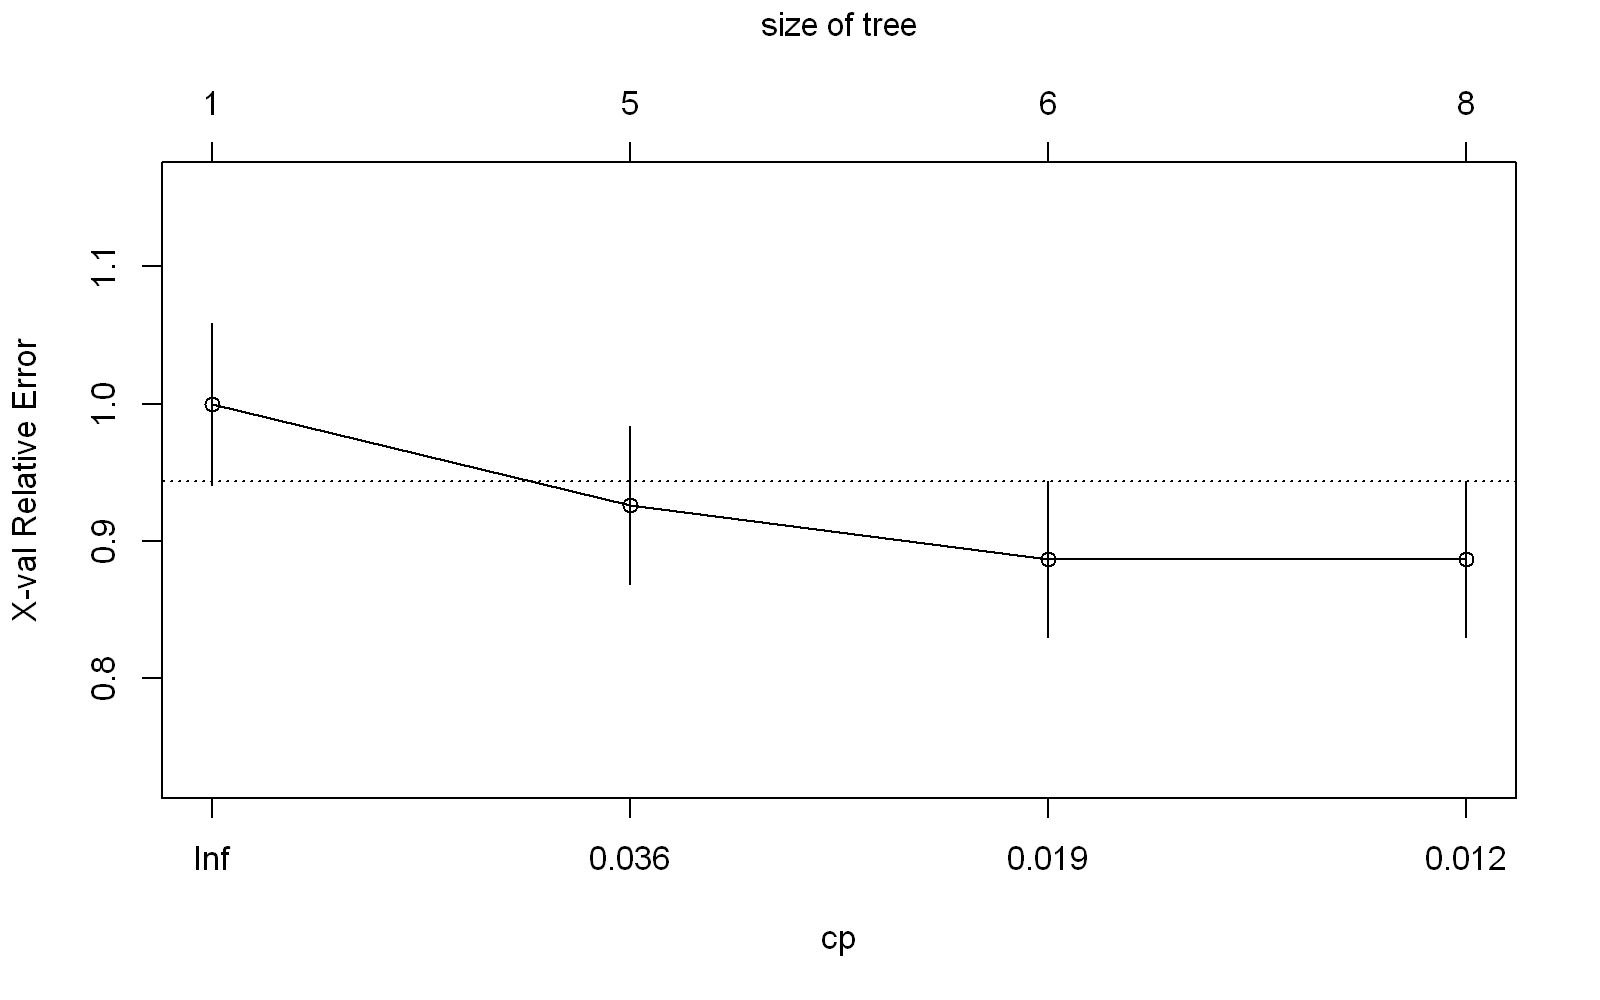

In [28]:
plotcp(dt.model)

* 가지치기 수행

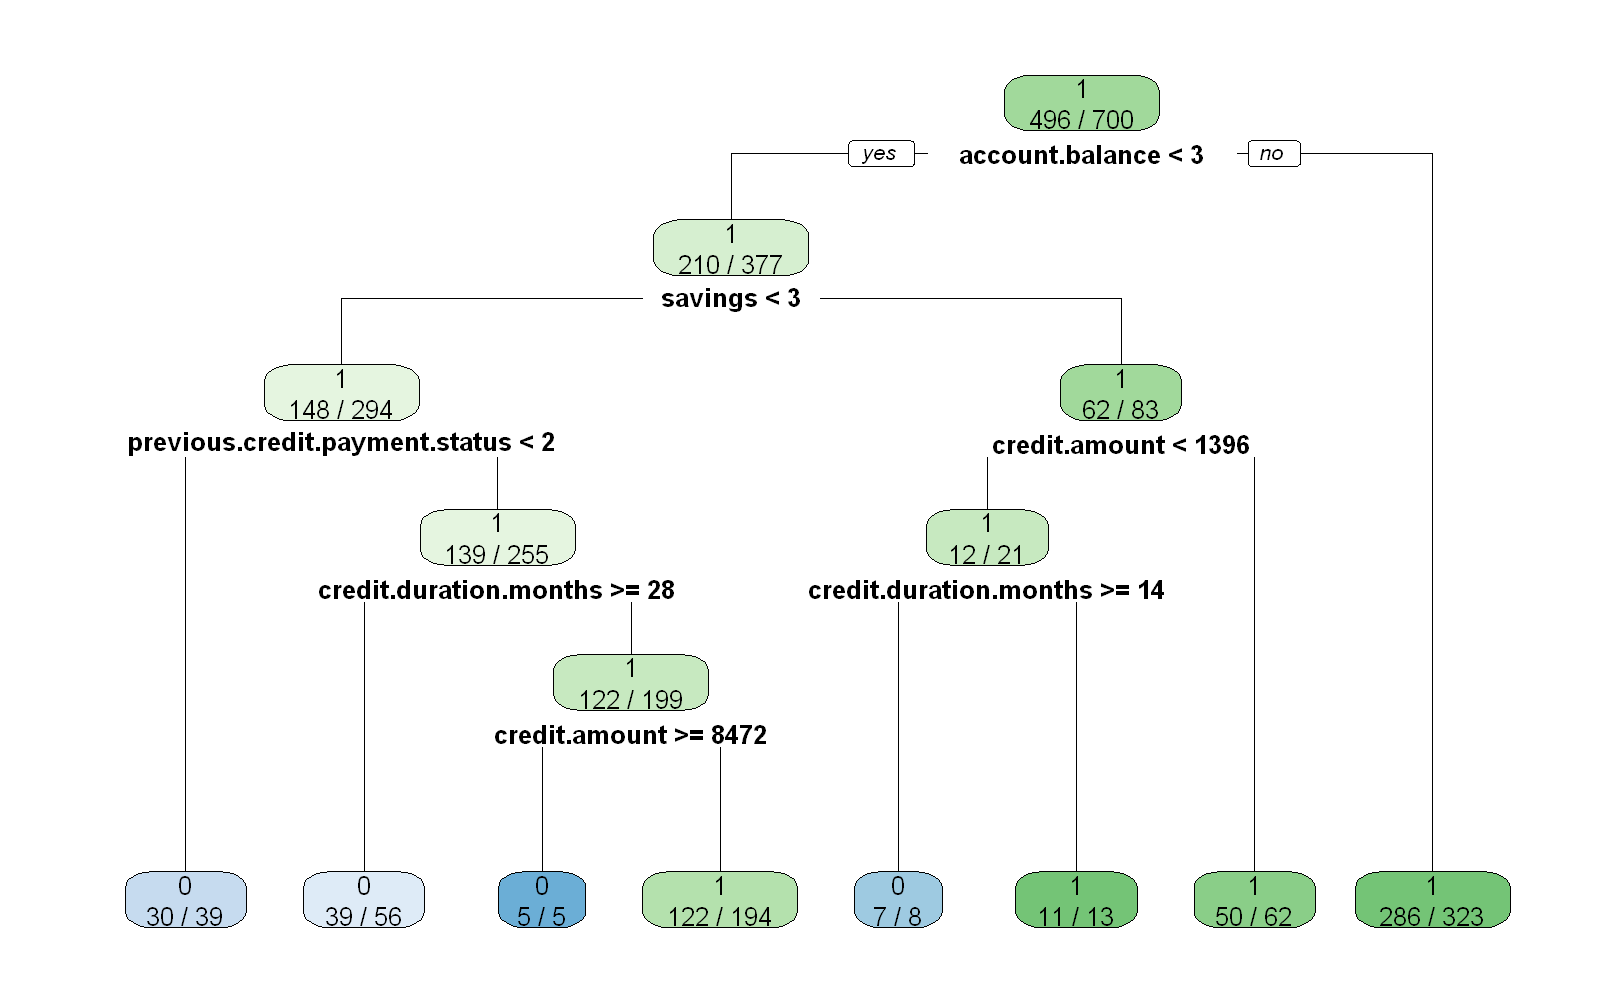

In [29]:
options(repr.plot.res=200)
rpart.plot(dt.model,extra=2) ## extra 인자를 이용해 각각 범주의 분류된 개수를 파악, extra=3 은 오분류된 개수를 보여준다

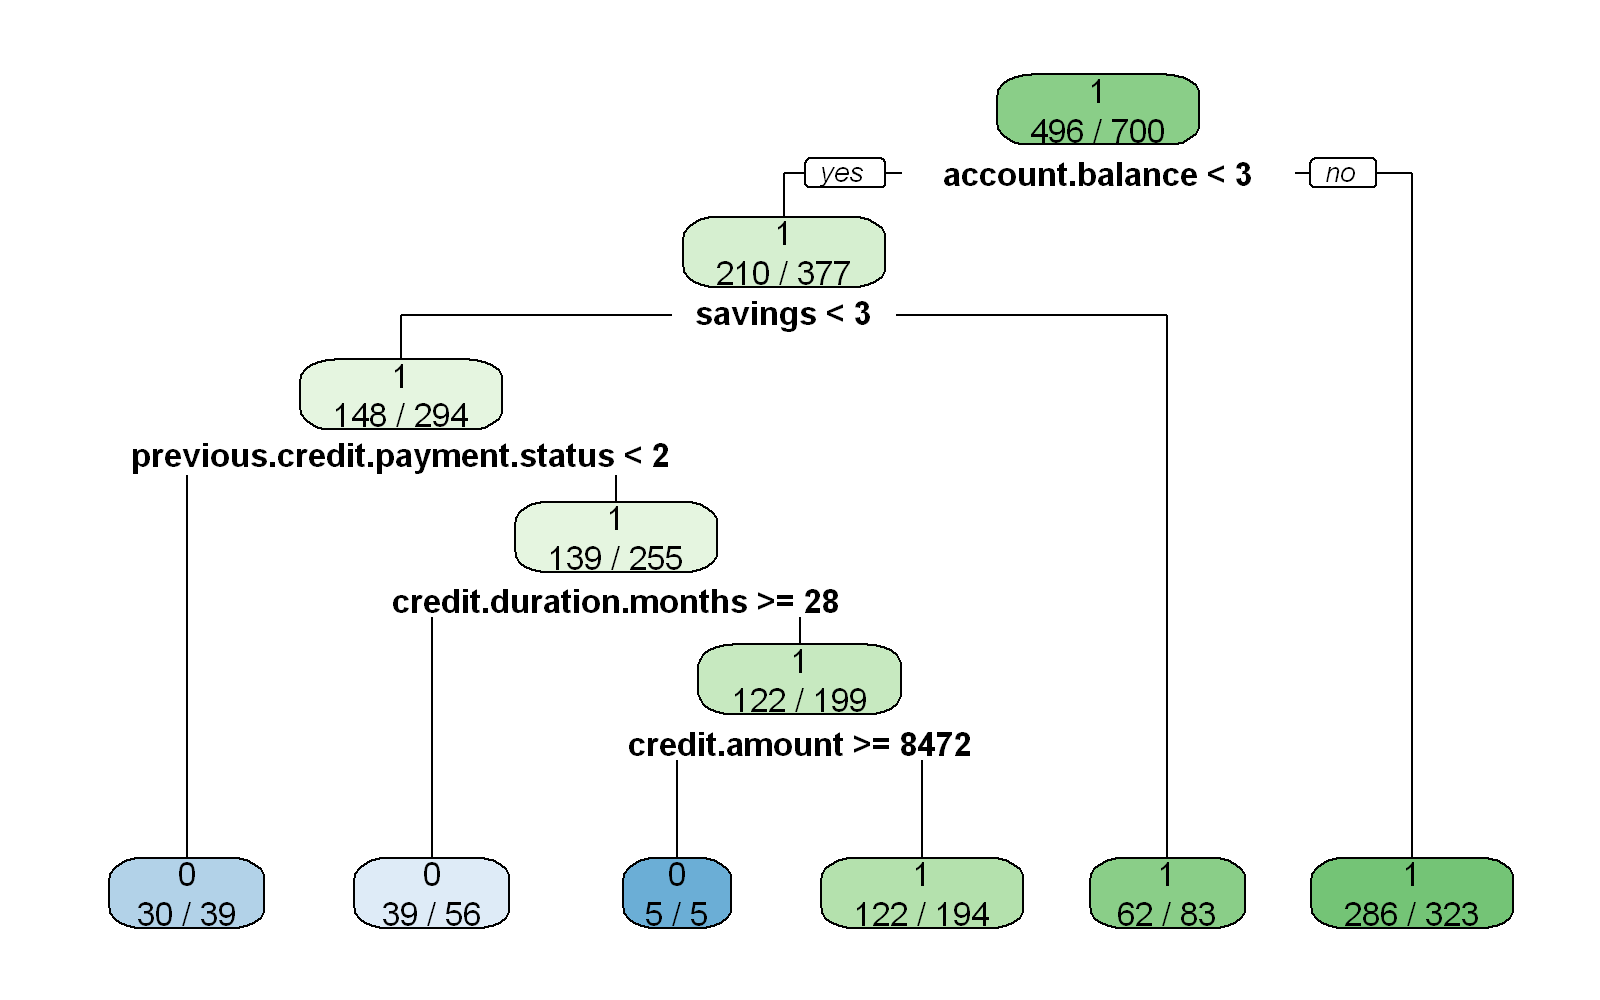

In [30]:
prune.c <- prune(dt.model,cp=cp)
rpart.plot(prune.c,extra=2)

* 기존의 모델보다 복잡성이 줄어든 것으로 볼 수 있다.

* 예측을 통하여 우리가 생성한 모델의 타당성을 평가하자.

In [31]:
pred.dt <- predict(dt.model, test %>% select(-1),type="class")

In [32]:
confusionMatrix(data=pred.dt,reference= test$credit.rating)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  37  19
         1  59 185
                                          
               Accuracy : 0.74            
                 95% CI : (0.6865, 0.7887)
    No Information Rate : 0.68            
    P-Value [Acc > NIR] : 0.014           
                                          
                  Kappa : 0.3285          
                                          
 Mcnemar's Test P-Value : 1.006e-05       
                                          
            Sensitivity : 0.3854          
            Specificity : 0.9069          
         Pos Pred Value : 0.6607          
         Neg Pred Value : 0.7582          
             Prevalence : 0.3200          
         Detection Rate : 0.1233          
   Detection Prevalence : 0.1867          
      Balanced Accuracy : 0.6461          
                                          
       'Positive' Class : 0               
                              

* `정분류율`은 0.73이며 `특이도`, `민감도`는 각각 0.8578, 0.4270으로 산출되었다.

In [33]:
pred.dt.roc <- prediction(as.numeric(pred.dt),as.numeric(test$credit.rating))

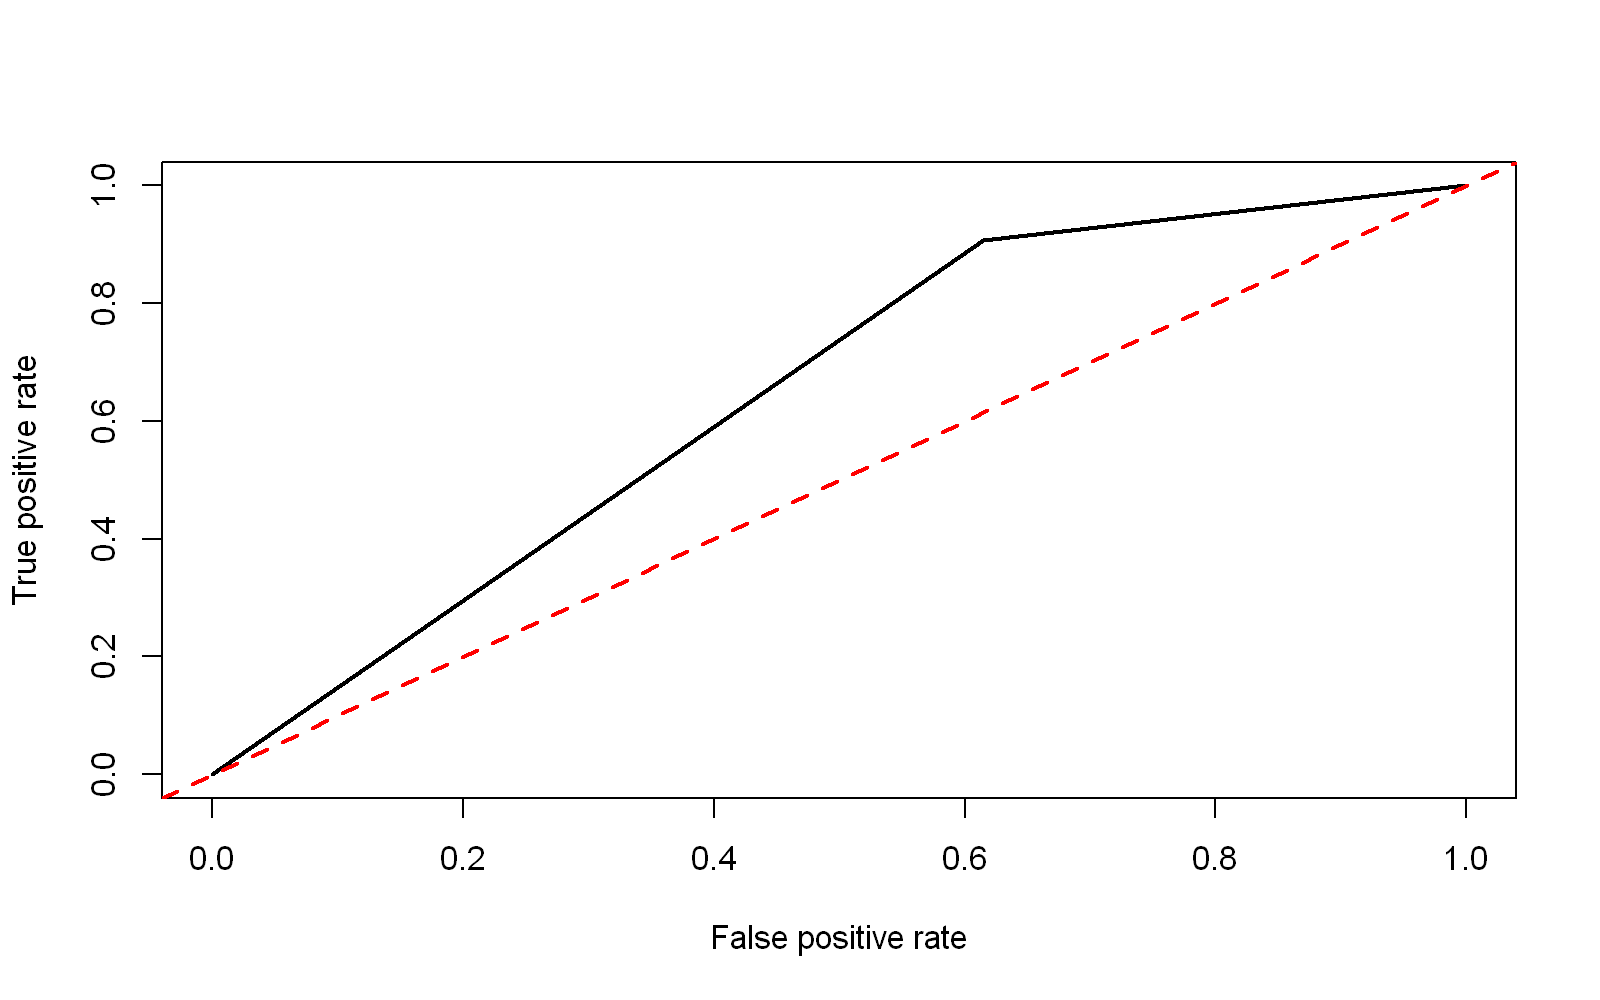

In [34]:
plot(performance(pred.dt.roc,"tpr","fpr"),lwd=2)
abline(a=0,b=1,lty=2,col="red",lwd=2)

In [35]:
performance(pred.dt.roc,"auc")@y.values

[[1]]
[1] 0.6461397

* 산출된 AUC값은 `0.642`로 좋은 모델은 아니다.

## 2-2.  multiple classification

In [36]:
dt.model2 <- rpart(Species ~. ,data=train.iris)

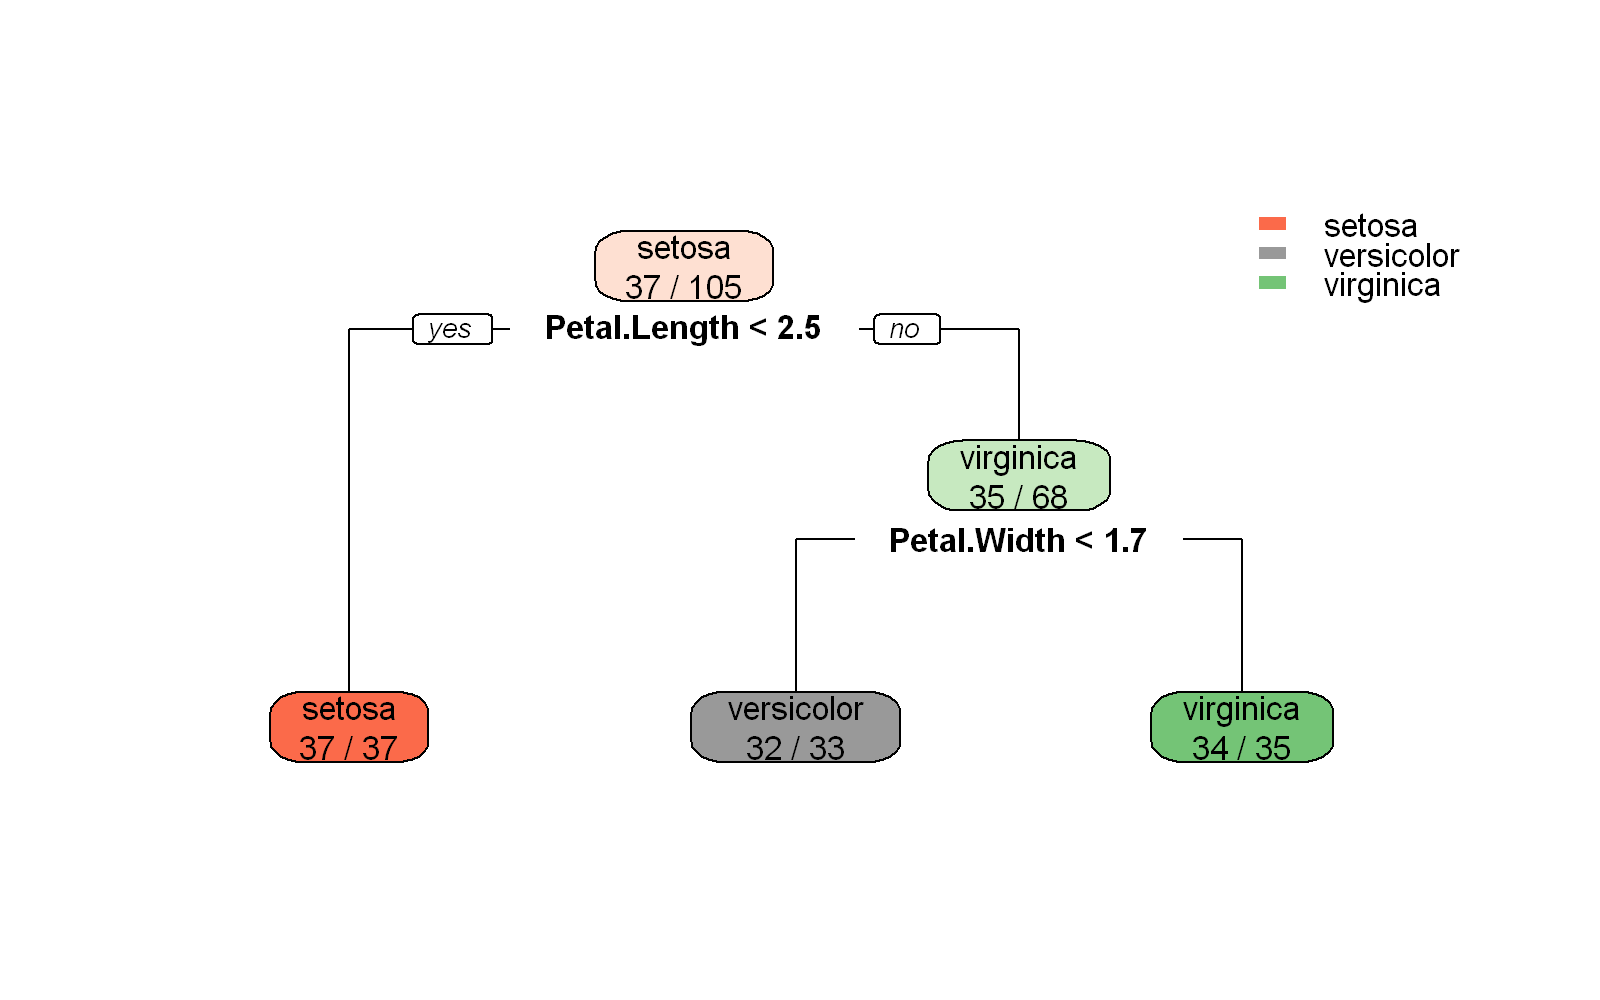

In [37]:
rpart.plot(dt.model2,extra=2)

* 총 105개의 데이터에서 39개의 데이터가 `virginica`로 분류되었고, `Petal.Length < 2.5`인 34개의 데이터는 모두 `setosa`로 분류되었다.

In [38]:
pred.dt2 <- predict(dt.model2, test.iris %>% select(-5),type="class")

In [40]:
confusionMatrix(pred.dt2,test.iris$Species)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         13          0         0
  versicolor      0         16         3
  virginica       0          1        12

Overall Statistics
                                          
               Accuracy : 0.9111          
                 95% CI : (0.7878, 0.9752)
    No Information Rate : 0.3778          
    P-Value [Acc > NIR] : 1.099e-13       
                                          
                  Kappa : 0.8655          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9412           0.8000
Specificity                 1.0000            0.8929           0.9667
Pos Pred Value              1.0000            0.8421           0.9231
Neg Pred Value              1.0000            0.9615           0.9062
P

* 정확도의 `0.9556`, 각각의 `class`에서 특이도와 민감도를 확인해보니 적절한 분류가 이루어졌음을 알 수 있다.

***

# 3. 배깅

* 의사결정나무의 경우 학습자료의 작은 변화에 의해 예측모형이 크게 변한다. 즉 학습방법이 불안정하다.

* 배깅은 여러 개의 붓스트랩자료를 생성하고 각 붓스트랩 자료에 예측모형을 만든 후 결합하여 최종 예측모형을 만드는 방법이다.

$\divideontimes$ **붓스트랩 : 주어진 자료에서 동일한 크기의 표본을 랜덤 복원추출로 뽑은 자료를 의미한다.**

* 예측모형을 결합한다는 것은 평균을 내는 것과 같으며, Classification 문제의 경우는 평균을 내는 것이 무의미 하므로 다수결의 원칙 즉, `voting` 방식을 이용한다.

* `adabag` 패키지에서 제공하는 `bagging` 함수의 경우 코드실행속도가 매우 느리다.
* 따라서 `randomForest` 패키지에서 제공하는 `randomForest` 함수를 사용 
* `mtry` 는 매번 분할에 사용될 예측변수(x)에 개수, 해당 데이터는 총 20개의 예측변수를 가짐
* `randomForest`와 `bagging`의 차이점은 고려할 예측변수의 개수이다. `bagging`의 경우 모든 변수를 고려한다.

In [18]:
library(randomForest)
library(adabag) ## 이 패키지의 경우 코드실행속도가 매우 느리다.

In [20]:
bag <- randomForest(credit.rating ~. , data=train, 
                        mtry = 20,importance =T)
pred.bg <- predict(bag,test,type="class")
confusionMatrix(data = pred.bg, 
                reference = test$credit.rating,
                positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  49  27
         1  43 181
                                          
               Accuracy : 0.7667          
                 95% CI : (0.7146, 0.8134)
    No Information Rate : 0.6933          
    P-Value [Acc > NIR] : 0.00297         
                                          
                  Kappa : 0.4233          
                                          
 Mcnemar's Test P-Value : 0.07300         
                                          
            Sensitivity : 0.8702          
            Specificity : 0.5326          
         Pos Pred Value : 0.8080          
         Neg Pred Value : 0.6447          
             Prevalence : 0.6933          
         Detection Rate : 0.6033          
   Detection Prevalence : 0.7467          
      Balanced Accuracy : 0.7014          
                                          
       'Positive' Class : 1               
                              

[[1]]
[1] 0.7014005

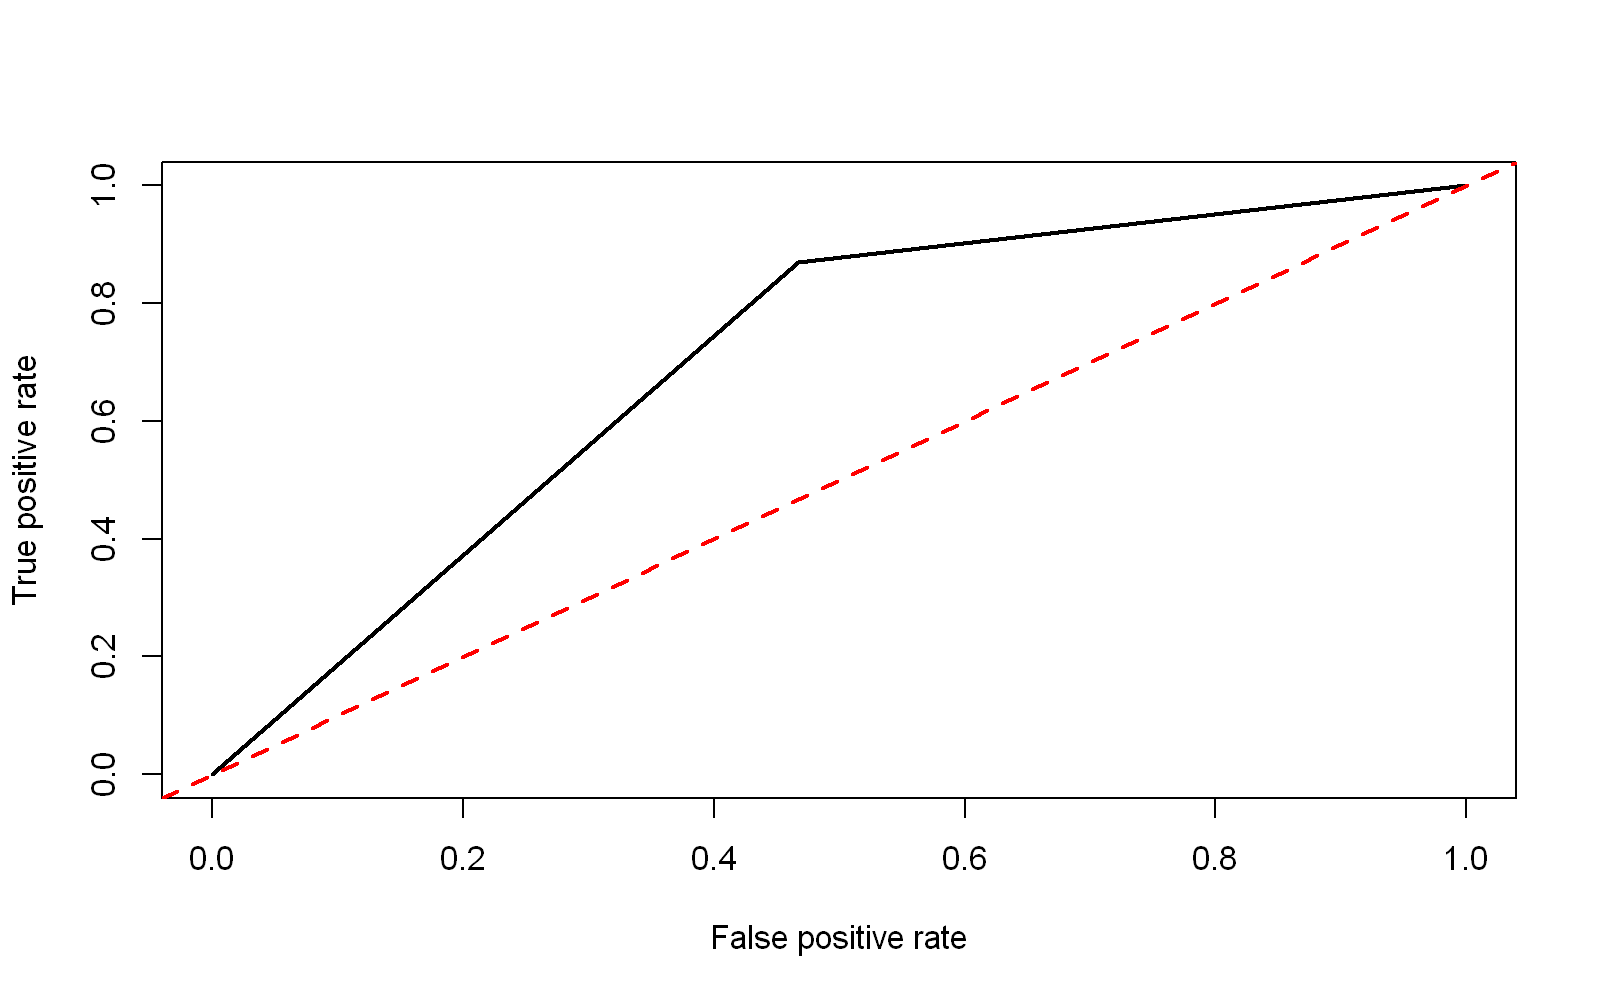

In [24]:
options(repr.plot.res=200,repr.plot.width=8,repr.plot.height=5)
pred.bg.roc <- prediction(as.numeric(pred.bg),as.numeric(test$credit.rating))
plot(performance(pred.bg.roc,"tpr","fpr"),lwd=2)
abline(a=0,b=1,col="red",lwd=2,lty="dashed")
performance(pred.bg.roc,"auc")@y.values

***

# 4. 부스팅

* 배깅과 달리 tree를 순차적으로 적합
* 전번 분류기에서 오분류율 정보를 이용하여 다음 번 분류기에서 가중치를 적합해 생성, 가중치의 합은 1
* 배깅은 샘플링을 이용하여 `n`개의 예측모형생성 후 다수결의 원칙을 적용
* 부스팅은 샘플링을 하지 않고 잔차에서 발생하는 정보를 활용하여 다음 분류기에 적합한다.

* 부스팅하고 배깅은 속도가 코드 구현 속도가 너무 느리다....

***

# 5. 랜덤포레스트

* 붓스트랩에 의해 생성되는 나무들 간의 상관성을 제거함으로써 최종 예측 모형의 분산을 획기적으로 감소시키고자 하는 방법
* 이는 소수의 강력한 예측변수들에 의해 모든 나무모형이 유사해지는 것을 막기 위해 매번 분할 시 `p`개의 예측 변수 중 `m` 개만 문할 기준의 후보로 삼음.

In [37]:
library(randomForest)

In [39]:
rf.model <- randomForest(credit.rating ~.,
                         data = train, ntree = 50,
                          mtry = sqrt(20),
                          importance=T)
rf.model


Call:
 randomForest(formula = credit.rating ~ ., data = train, ntree = 50,      mtry = sqrt(20), importance = T) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 4

        OOB estimate of  error rate: 26.86%
Confusion matrix:
   0   1 class.error
0 77 131   0.6298077
1 57 435   0.1158537

* `OOB estimate of error rate`는 에러추정치로서 값이 낮을수록 분류모델의 성능이 좋다고 판단할 수 있다.

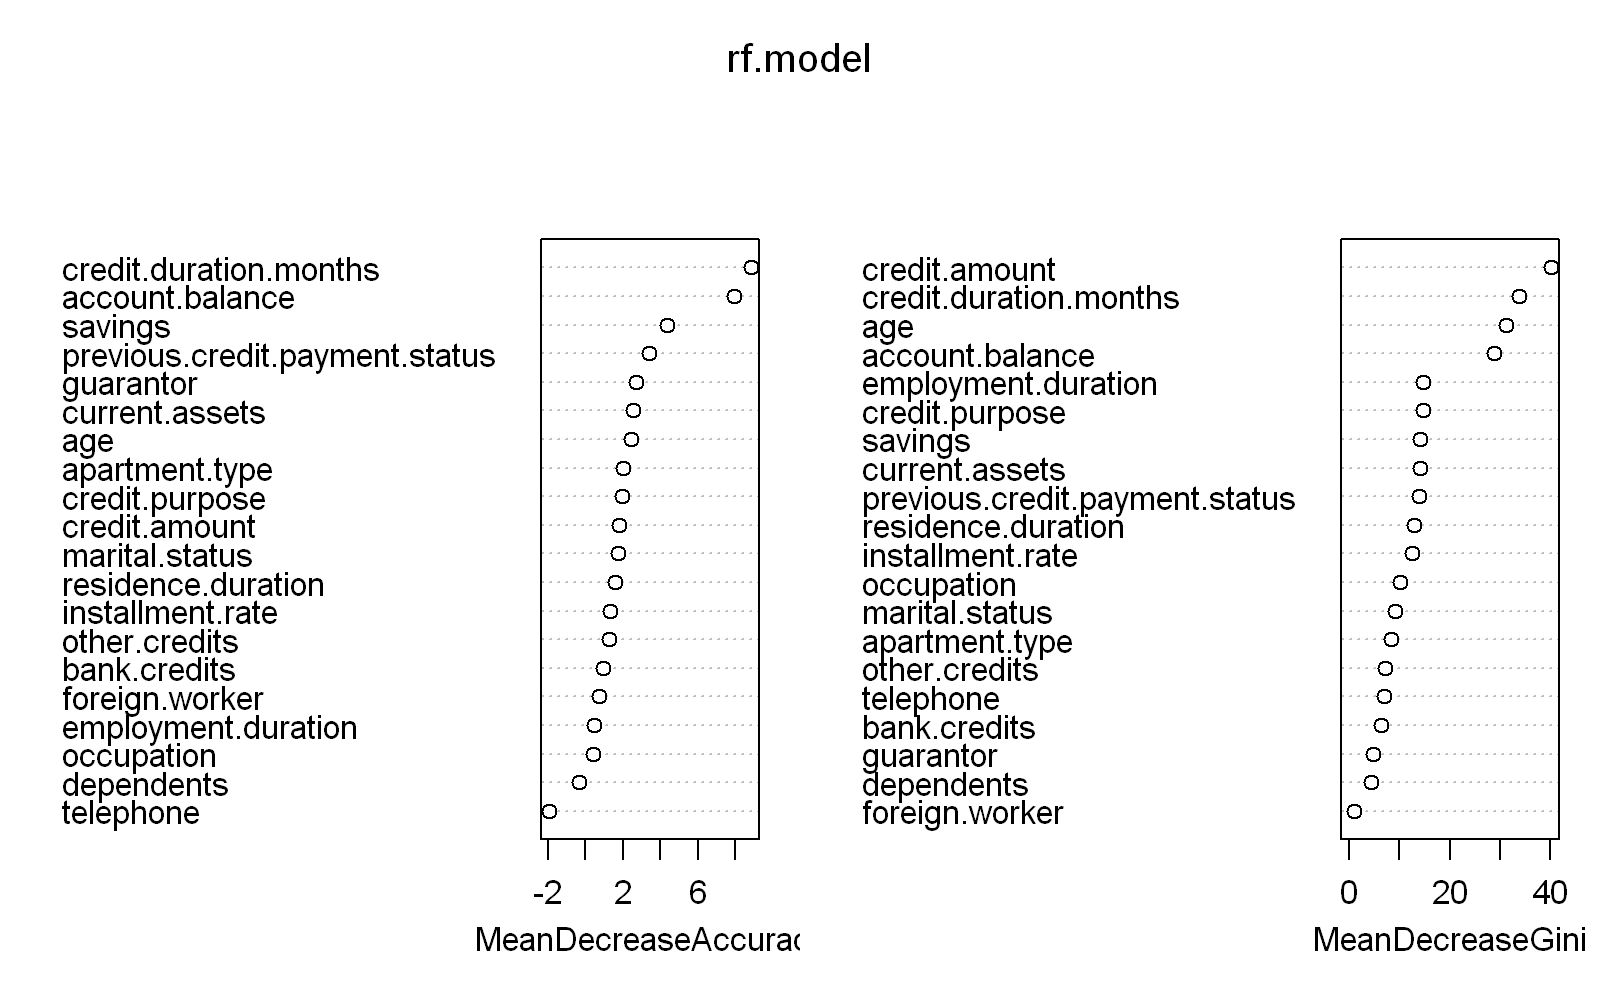

In [44]:
# rf.model$importance
varImpPlot(rf.model)

* 변수 중요도를 `MeanDecreaseGini` 기준으로 살펴보았을 때, `credit.amount`, `credit.duration.months`, `age` 순서로 변수 중요도가 크다는 것을 파악할 수 있다. 

In [46]:
pred.rf <-  predict(rf.model, test, type="class")
confusionMatrix(data = pred.rf, reference = test$credit.rating, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  38  19
         1  54 189
                                         
               Accuracy : 0.7567         
                 95% CI : (0.704, 0.8041)
    No Information Rate : 0.6933         
    P-Value [Acc > NIR] : 0.009216       
                                         
                  Kappa : 0.3599         
                                         
 Mcnemar's Test P-Value : 6.909e-05      
                                         
            Sensitivity : 0.9087         
            Specificity : 0.4130         
         Pos Pred Value : 0.7778         
         Neg Pred Value : 0.6667         
             Prevalence : 0.6933         
         Detection Rate : 0.6300         
   Detection Prevalence : 0.8100         
      Balanced Accuracy : 0.6608         
                                         
       'Positive' Class : 1              
                                         

[[1]]
[1] 0.6608487

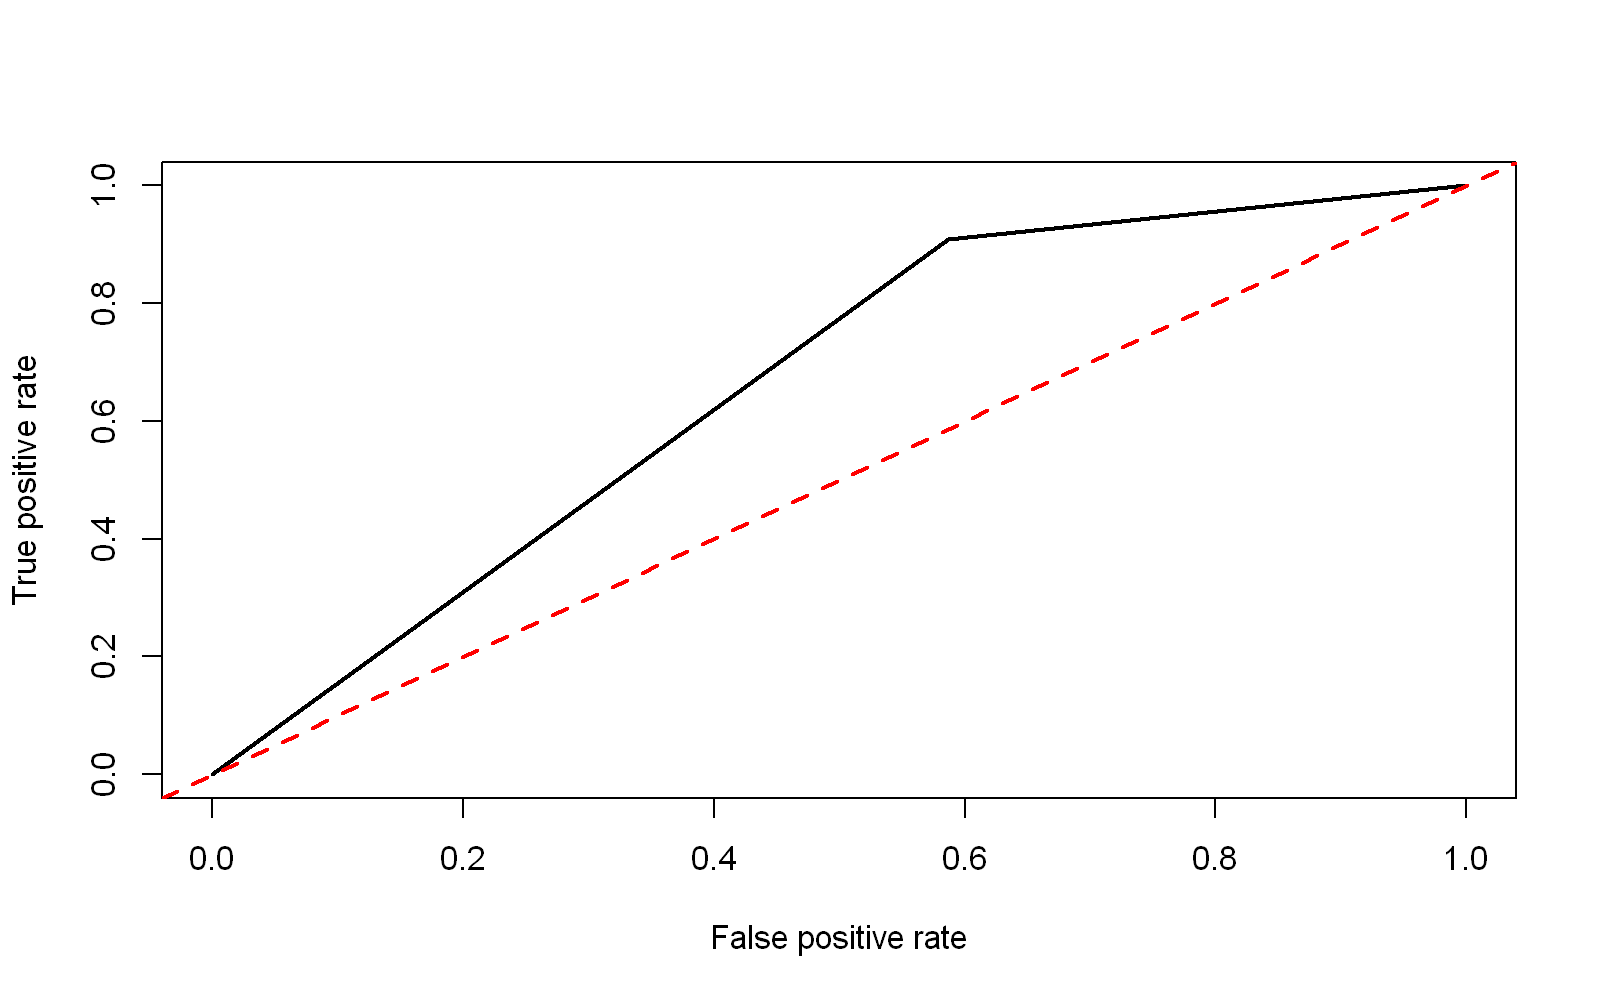

In [51]:
pred.rf.roc <- prediction(as.numeric(pred.rf), as.numeric(test$credit.rating))
plot(performance(pred.rf.roc,"tpr","fpr"),lwd=2)
abline(b=1,a=0,col="red",lty=2,lwd=2)
performance(pred.rf.roc,"auc")@y.values

# 6. SVM

* 각 그룹을 구분하는 분류자를 **결정 초평면 (decision hyperline)**, 각 그룹에 속한 데이터들 중에서도 **초평면에 가장 가까이에 붙어있는 최전방 데이터들을 서포트 벡터(support vector), 서포트 벡터와 초평면 사이의 수직거리를 마진(mergin)**,이라고 한다. 

* SVM은 고차원 혹은 무한 차원의 공간에서 마진을 최대화하는 초평면을 찾아 **분류와 회귀**를 수행한다.
* 모형을 적합하기 전 `tune.svm` 함수로 최적의 파라미터를 찾는다.
* `gamma` : 초평면의 기울기, default = 1/(데이터차원)
* `cost` : 과적합을 막는 정도로 오분류의 허용한계이다. cost가 클수록 마진이 넓고, 적을 수록 마진이 좁다. dafault = 1

In [54]:
library(e1071)

In [53]:
tune.svm(credit.rating ~., data = credit_data,
                          gamma = 10^(-6:-1),
                          cost = 10^(1:2))


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
  0.01   10

- best performance: 0.232 


* 위와 같은 경우 `6 x 2 = 12` 총 12개의 조합에서 모수조율이 이루어진다.

* `kernel` : radial, linear, polynomial, sigmoid 등이 있는데 실제 문제에서 커널의 선택이 결과의 정확도에 큰 영향을 주지 않는다.

In [55]:
svm.model  <- svm(credit.rating~.,
                  data =train,
                  kernel ="radial",
                  gamma = 0.01,
                  cost = 10)

In [56]:
summary(svm.model)


Call:
svm(formula = credit.rating ~ ., data = train, kernel = "radial", 
    gamma = 0.01, cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  402

 ( 187 215 )


Number of Classes:  2 

Levels: 
 0 1




In [57]:
pred.svm <- predict(svm.model, test, type="class")
confusionMatrix(data = pred.svm, reference = test$credit.rating,positive= "1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  39  22
         1  53 186
                                        
               Accuracy : 0.75          
                 95% CI : (0.697, 0.798)
    No Information Rate : 0.6933        
    P-Value [Acc > NIR] : 0.018050      
                                        
                  Kappa : 0.3511        
                                        
 Mcnemar's Test P-Value : 0.000532      
                                        
            Sensitivity : 0.8942        
            Specificity : 0.4239        
         Pos Pred Value : 0.7782        
         Neg Pred Value : 0.6393        
             Prevalence : 0.6933        
         Detection Rate : 0.6200        
   Detection Prevalence : 0.7967        
      Balanced Accuracy : 0.6591        
                                        
       'Positive' Class : 1             
                                        

[[1]]
[1] 0.6590719

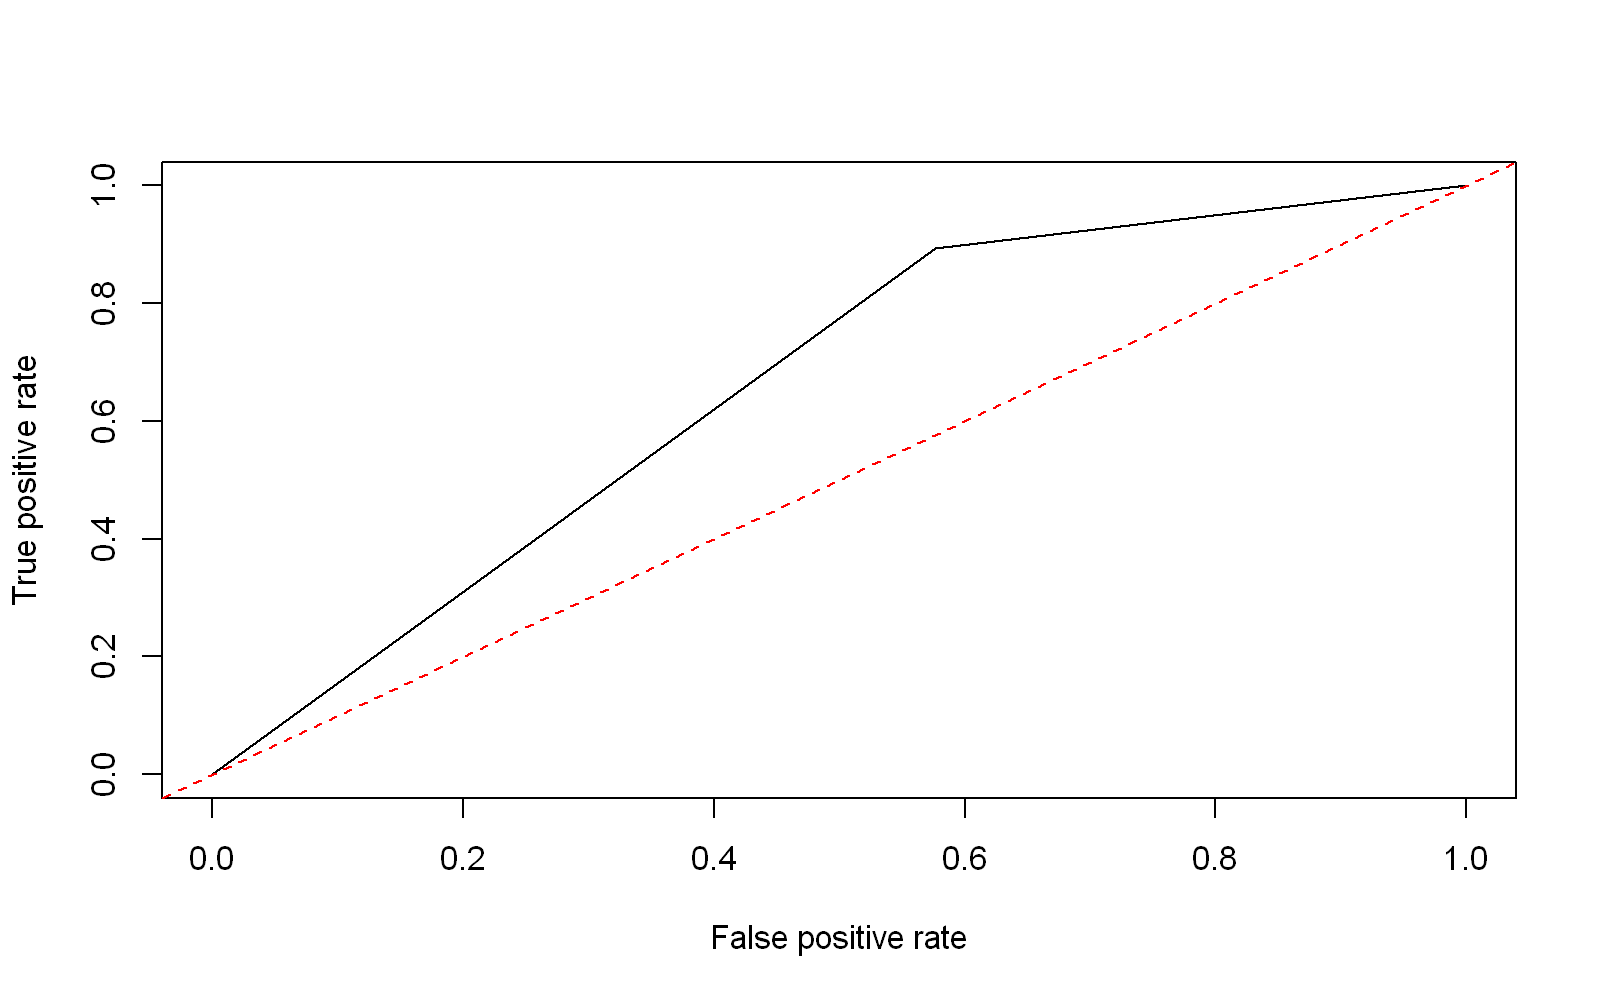

In [62]:
pred.svm.roc <- prediction(as.numeric(pred.svm),as.numeric(test$credit.rating))
plot(performance(pred.svm.roc,"tpr","fpr"))
abline(a=0,b=1,col="red",lty=2)
performance(pred.svm.roc,"auc")@y.values

# 7. 나이브 베이즈 분류

* $C_i = label \, of \, class$
* $X=(X_1,X_2,\dots X_n)$

 * $\begin {eqnarray*}posterior=P(C_i | X) = \frac {P(C_i)P(X|C_i)}{P(X)}\end{eqnarray*} = \frac {prior \times likelhood}{evidence}$ 

* $P(X | C_i)= \prod_{k=1}^n P(X_k|C_i) = P(x_1|C_i)\times \dots P(x_n |C_i)$

* 클래스 조건 독립성 : 위 식처럼 속성값에 대해 다른 속성이 독립적이라는 가정이다.

* 즉 $X$라는 속성값들이 주어져있을 때 사전확률값과 관측값을 이용하여 사후확률을 구하여 개체를 해당 클래스로 분류하는 기법이다.

In [63]:
library(e1071)

* `laplace` : 라플라스 보정여부, 뭔지는 잘 모르겠음..

In [65]:
nb.model  <- naiveBayes(credit.rating ~ . ,data = train , laplace=0)

In [66]:
nb.model


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
        0         1 
0.2971429 0.7028571 

Conditional probabilities:
   account.balance
Y       [,1]      [,2]
  0 1.759615 0.8045185
  1 2.394309 0.8066729

   credit.duration.months
Y       [,1]     [,2]
  0 25.24038 13.26358
  1 19.23984 11.38457

   previous.credit.payment.status
Y       [,1]      [,2]
  0 2.081731 0.6505686
  1 2.365854 0.5955475

   credit.purpose
Y       [,1]      [,2]
  0 3.149038 0.9178314
  1 2.900407 0.9929691

   credit.amount
Y       [,1]     [,2]
  0 3841.731 3393.693
  1 3035.821 2507.385

   savings
Y       [,1]     [,2]
  0 1.586538 1.036629
  1 2.002033 1.244947

   employment.duration
Y       [,1]     [,2]
  0 2.250000 1.135718
  1 2.518293 1.072557

   installment.rate
Y       [,1]     [,2]
  0 3.158654 1.062684
  1 2.914634 1.124088

   marital.status
Y       [,1]     [,2]
  0 2.250000 1.096767
  1 2.439024 1.049848

* `A-priori probabilities` 는 사전확률을 나타내고 있으며, `Conditional Probabilities`는 각 변수에 대한 조건부 확률이다.

In [68]:
pred.nb <- predict(nb.model,test, type="class")
confusionMatrix(data= pred.nb,reference = test$credit.rating,positive="1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  59  36
         1  33 172
                                          
               Accuracy : 0.77            
                 95% CI : (0.7182, 0.8164)
    No Information Rate : 0.6933          
    P-Value [Acc > NIR] : 0.001967        
                                          
                  Kappa : 0.464           
                                          
 Mcnemar's Test P-Value : 0.809732        
                                          
            Sensitivity : 0.8269          
            Specificity : 0.6413          
         Pos Pred Value : 0.8390          
         Neg Pred Value : 0.6211          
             Prevalence : 0.6933          
         Detection Rate : 0.5733          
   Detection Prevalence : 0.6833          
      Balanced Accuracy : 0.7341          
                                          
       'Positive' Class : 1               
                              

[[1]]
[1] 0.7341137

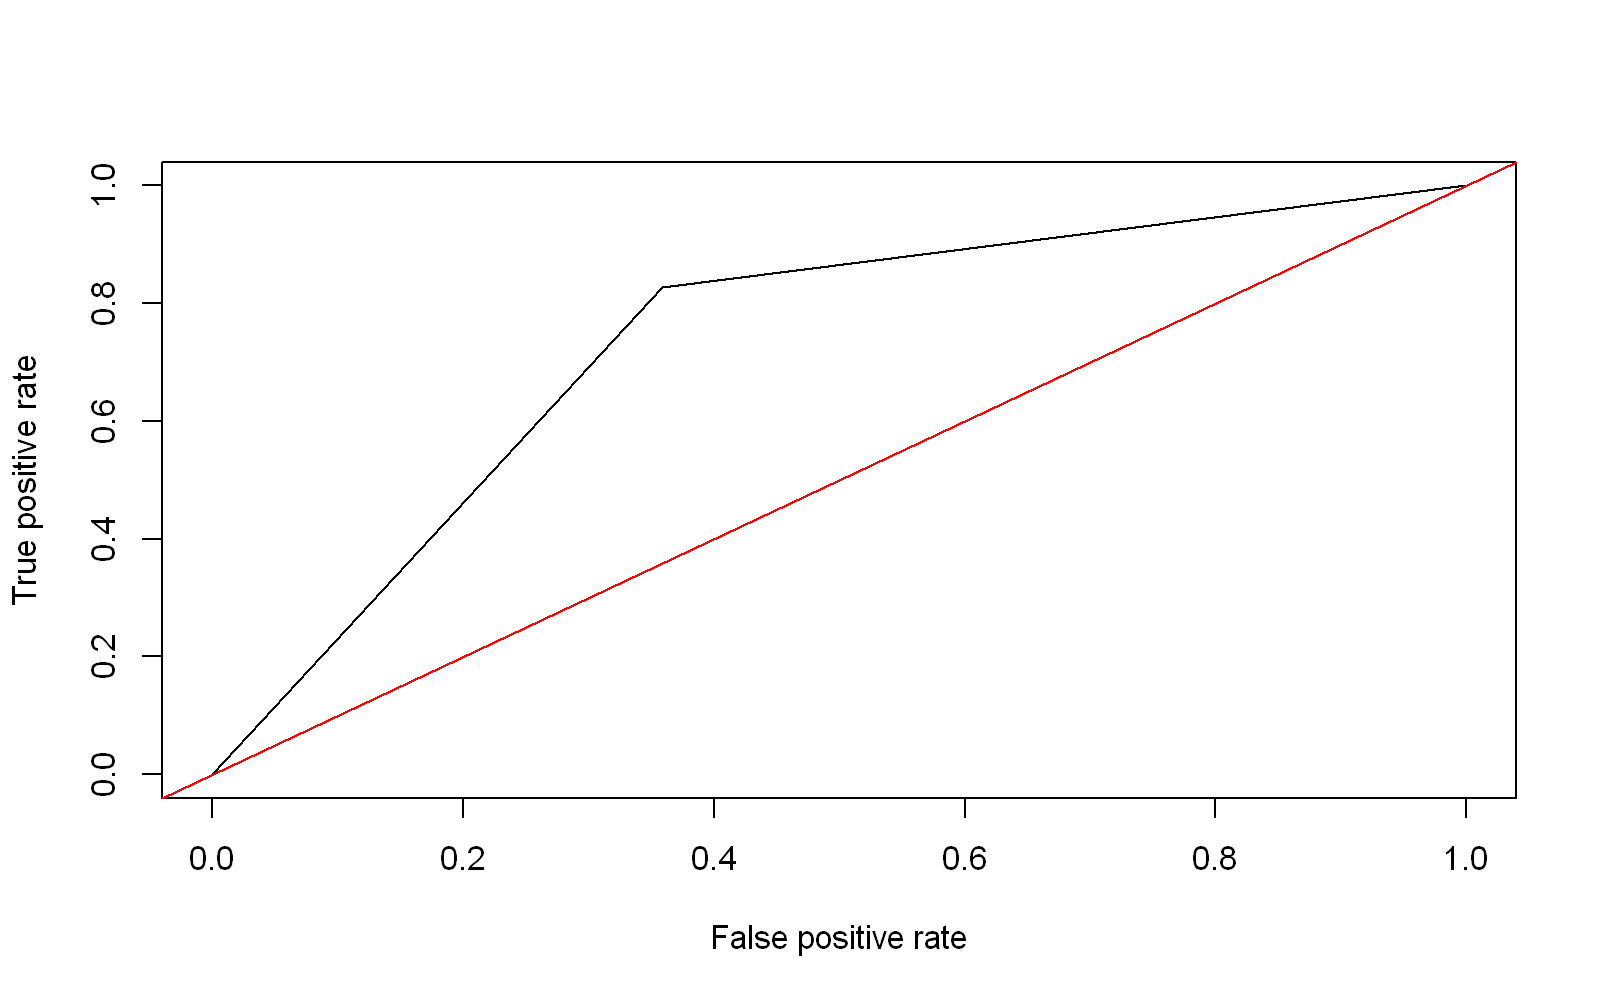

In [71]:
pred.nb.roc  <- prediction(as.numeric(pred.nb),as.numeric(test$credit.rating))
plot(performance(pred.nb.roc,"tpr","fpr"))
abline(b=1,a=0,col="red"); performance(pred.nb.roc,"auc")@y.values

***

# 8. K-NN(K-Nearest Neighbor)

* K-NN 알고리즘에서는 새로운 데이터의 클래스를 해당 데이터와 가장 가까운 `k`개 데이터들의 클래스(범주)로 결정한다.
* 최근접 이웃 간의 거리를 계산할 때 유클리디안 거리, 맨하탄 거리, 민코우스키 거리 등을 사용할 수 있으며, 대표적으로 **유클리디안 거리**를 사용한다.

In [72]:
library(class)

In [76]:
train.data <- train %>% select(-1)
test.data <- test %>% select(-1)
class <- train$credit.rating

knn.3 <- knn(train.data,test.data, class, k=3 )
knn.7 <- knn(train.data,test.data, class, k=7 )
knn.10 <- knn(train.data,test.data, class, k=10 )

In [79]:
confusionMatrix(knn.3, test$credit.rating,positive="1")
confusionMatrix(knn.7, test$credit.rating,positive="1")
confusionMatrix(knn.10, test$credit.rating,positive="1")


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  28  43
         1  64 165
                                          
               Accuracy : 0.6433          
                 95% CI : (0.5863, 0.6975)
    No Information Rate : 0.6933          
    P-Value [Acc > NIR] : 0.97262         
                                          
                  Kappa : 0.1043          
                                          
 Mcnemar's Test P-Value : 0.05318         
                                          
            Sensitivity : 0.7933          
            Specificity : 0.3043          
         Pos Pred Value : 0.7205          
         Neg Pred Value : 0.3944          
             Prevalence : 0.6933          
         Detection Rate : 0.5500          
   Detection Prevalence : 0.7633          
      Balanced Accuracy : 0.5488          
                                          
       'Positive' Class : 1               
                              

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  17  18
         1  75 190
                                          
               Accuracy : 0.69            
                 95% CI : (0.6343, 0.7419)
    No Information Rate : 0.6933          
    P-Value [Acc > NIR] : 0.5775          
                                          
                  Kappa : 0.1188          
                                          
 Mcnemar's Test P-Value : 6.363e-09       
                                          
            Sensitivity : 0.9135          
            Specificity : 0.1848          
         Pos Pred Value : 0.7170          
         Neg Pred Value : 0.4857          
             Prevalence : 0.6933          
         Detection Rate : 0.6333          
   Detection Prevalence : 0.8833          
      Balanced Accuracy : 0.5491          
                                          
       'Positive' Class : 1               
                              

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  13  10
         1  79 198
                                          
               Accuracy : 0.7033          
                 95% CI : (0.6481, 0.7545)
    No Information Rate : 0.6933          
    P-Value [Acc > NIR] : 0.3799          
                                          
                  Kappa : 0.1179          
                                          
 Mcnemar's Test P-Value : 5.679e-13       
                                          
            Sensitivity : 0.9519          
            Specificity : 0.1413          
         Pos Pred Value : 0.7148          
         Neg Pred Value : 0.5652          
             Prevalence : 0.6933          
         Detection Rate : 0.6600          
   Detection Prevalence : 0.9233          
      Balanced Accuracy : 0.5466          
                                          
       'Positive' Class : 1               
                              

* 적절한 `k`값을 찾기 위해 `k`값을 변경해 가면서 확인하여야한다.

***

# 9. 인공신경망 모형 (Artificial Nerual Network)

In [7]:
library(nnet)

* size = hidden node의 개수
* maxit = 학습 반복 횟수, 반복 중 가장 좋은 모델을 선정함.
* decay = 가중치 감소의 모수, 보통 0.0005 채택

In [16]:
nn.model <- nnet(credit.rating~.,data=train,
                                  size = 2,
                                  maxit = 200,
                                  decay = 0.0005)

# weights:  45
initial  value 465.171750 
iter  10 value 431.758720
iter  20 value 431.756746
iter  30 value 423.013724
iter  40 value 385.108066
iter  50 value 369.426057
iter  60 value 362.889778
iter  70 value 361.595605
iter  80 value 361.468176
iter  90 value 361.461934
iter 100 value 361.461857
final  value 361.461791 
converged


* 최종 error 값이 `425.896932`로 `final value`를 보고 확인할 수 있다.

In [17]:
summary(nn.model)

a 20-2-1 network with 45 weights
options were - entropy fitting  decay=5e-04
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.01   -0.01    0.01   -0.01    0.00    0.05    0.01    0.01   -0.01    0.01 
i10->h1 i11->h1 i12->h1 i13->h1 i14->h1 i15->h1 i16->h1 i17->h1 i18->h1 i19->h1 
   0.01    0.01    0.01    0.02    0.00    0.01    0.01    0.01    0.00   -0.01 
i20->h1 
  -0.01 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -18.85   32.55   -5.06    2.17  -15.94    0.02   11.73   17.82   -3.15    3.52 
i10->h2 i11->h2 i12->h2 i13->h2 i14->h2 i15->h2 i16->h2 i17->h2 i18->h2 i19->h2 
  13.88    1.02  -13.90    1.34   -7.07    0.02   -5.22  -10.24   -5.20   29.20 
i20->h2 
  -0.08 
  b->o  h1->o  h2->o 
 -0.35  -0.38   2.25 

* `neuralnet` 패키지를 이용

In [19]:
library(neuralnet)

In [20]:
data(infert)
infert$case <- as.factor(infert$case)

In [21]:
train.infert <- infert %>% sample_frac(0.7)
test.infert  <-  infert  %>% setdiff(train.infert)

* `algorithm` : 사용할 알고리즘 ( `backprop(역전파)`, `rprop+(default)`,`rprop-`)
* `thresold` : 훈련중단 기준으로 default = 0.01
* `hidden` : 은닉노드의 개수 c(n,m)-> n = 첫 번째 은닉층은 n개의 은닉노드, m = 두 번째 은닉층의 m개의 은닉노드
* `stepmax` : 인공 신경망 훈련 수행 최대횟수
* `err.fct` : 손실함수 지정 -> `ce` : 크로스 엔트로피, `sse` : 잔차제곱합
* `linear.output` : 활성화함수를 사용하지 않는다면 `TRUE`로 입력해야함.
* `likelihood` : 에러함수에 대한 우도함수를 지정해주는 것, 만약 에러 함수가 음의 로그-우도 함수가 아니면, likelhood는 TRUE이여야 한다., 그러면  `AIC,BIC`가 계산되는 것을 기반으로 한다.
* `acc.fct` : 활성화 함수로 `logistice, tanh` 인자가 입력 가능하다.

In [36]:
nn.model2 <- neuralnet(case ~ age+parity+induced + spontaneous,data=train.infert,
                       hidden =3,
                       algorithm="rprop+",
                       threshold=0.01)

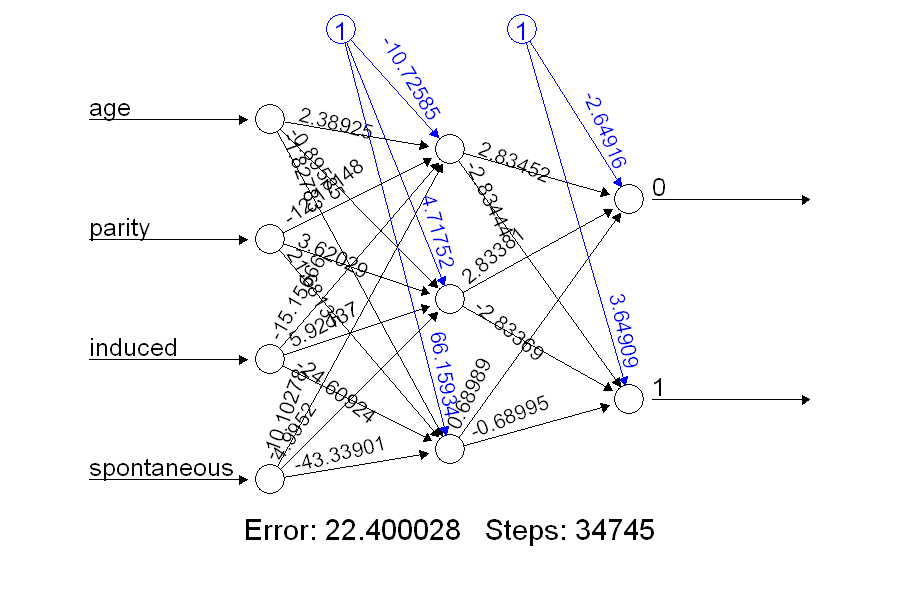

In [37]:
options(repr.plot.res=150,repr.plot.width=6,repr.plot.height=4)
plot(nn.model2,rep="best")

In [38]:
test.infert$nn.model2_pred.prob <- compute(nn.model2,covariate=test.infert[,c(2:4,6)])$net.result
test.infert$nn.model2_pred <- ifelse(test.infert$nn.model2_pred.prob>0.5,1,0)

In [40]:
test.infert$nn.model2_pred

1,0
0,1
1,0
1,0
0,1
1,0
1,0
0,1
0,1
0,1
0,1


In [39]:
confusionMatrix(as.factor(test.infert$nn.model2_pred),test.infert$case)

ERROR: Error in table(data, reference, dnn = dnn, ...): 모든 인자들은 반드시 같은 길이를 가져야 합니다


* 인공신경망 쪽은 다시 체크하자!